# Exploring data

In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data_dir = 'toy_data'
train_img_dir = f"{data_dir}/train_images"
test_img_dir = f"{data_dir}/test_images"

train_csv = f"{data_dir}/train.csv"
test_csv = f"{data_dir}/test.csv"

In [3]:
train_df = pd.read_csv(train_csv)

FileNotFoundError: [Errno 2] No such file or directory: 'toy_data/train.csv'

In [4]:
import pydicom

def read_img(img_path):
    img = pydicom.dcmread(img_path).pixel_array
    img = img * 255.0/img.max()
    return img.astype(np.int16)

def plot_pics(img_id):
    img_dir = f"{train_img_dir}/{img_id}"
    pics = os.listdir(img_dir)

    fig, axs = plt.subplots(1, len(pics), figsize=(len(pics)*5,5))

    for i, pic in enumerate(pics):
        pic_full_path = f"{img_dir}/{pic}"
        print(pic_full_path)
        img = read_img(pic_full_path)
        axs[i].imshow(img, cmap=plt.cm.gray)
        img_id = int(pic.split(".")[0])
        cancer = train_df[train_df['image_id'] == img_id]['cancer'].values[0]
        cancer_dict = {0: "", 1: "CANCER"}
        axs[i].set_title(cancer_dict[cancer])

toy_data/train_images/64956/1305773827.dcm
toy_data/train_images/64956/742080106.dcm
toy_data/train_images/64956/1997115272.dcm
toy_data/train_images/64956/2003060027.dcm


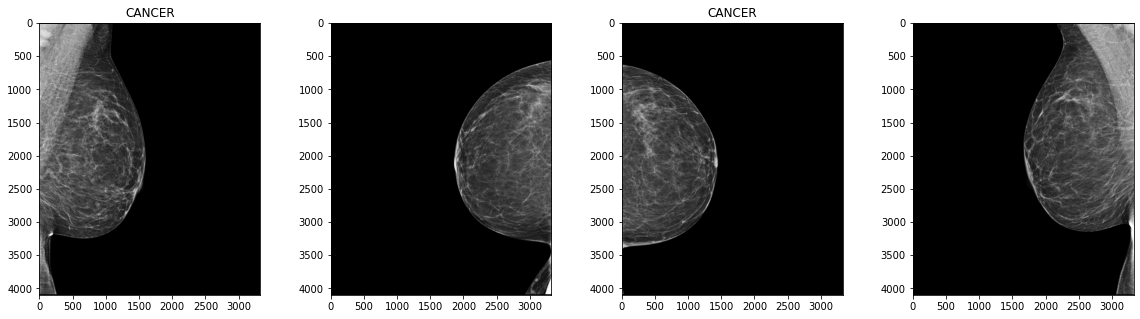

In [5]:
sample_img_id = 64956
plot_pics(sample_img_id)

# Superpixel segmentation

<Figure size 720x720 with 0 Axes>

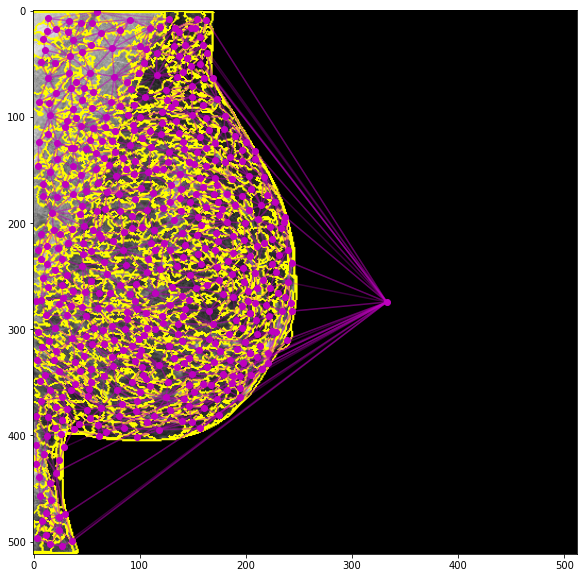

In [6]:
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
from matplotlib.lines import Line2D

def segment_img(img):
    return felzenszwalb(img, scale=100, sigma=0.25, min_size=50, channel_axis=None)


sample_img_path = "64956_1305773827.png"
img = plt.imread(sample_img_path)

fig = plt.figure(figsize=(10,10))
segments = segment_img(img)

segments_ids = np.unique(segments)
centers = np.array([np.mean(np.nonzero(segments==i),axis=1) for i in segments_ids])

vs_right = np.vstack([segments[:,:-1].ravel(), segments[:,1:].ravel()])
vs_below = np.vstack([segments[:-1,:].ravel(), segments[1:,:].ravel()])
bneighbors = np.unique(np.hstack([vs_right, vs_below]), axis=1)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# plt.imshow(img, cmap=plt.cm.gray)
plt.imshow(mark_boundaries(img, segments)) 
plt.scatter(centers[:,1],centers[:,0], c='m')

for i in range(bneighbors.shape[1]):
    y0,x0 = centers[bneighbors[0,i]]
    y1,x1 = centers[bneighbors[1,i]]

    l = Line2D([x0,x1],[y0,y1], alpha=0.3, c='m')
    ax.add_line(l)

# plt.imshow(mark_boundaries(np.array(img), segments))

# Featurizing superpixels

{'segment_id': 155,
 'std': 0.051799852,
 'mean': 0.19864774,
 'entropy': 5.733493}

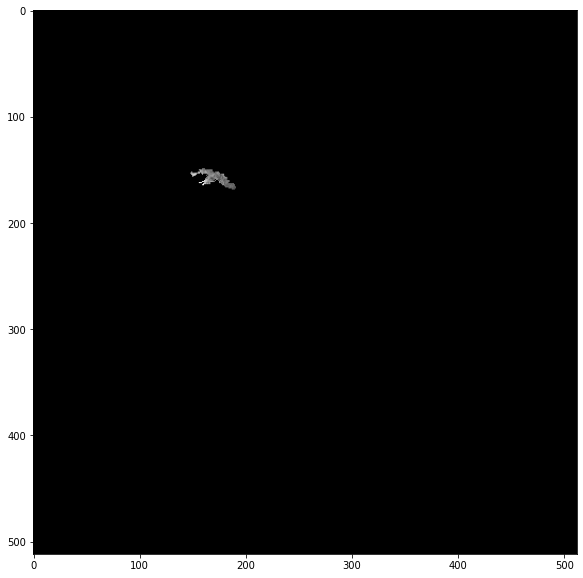

In [7]:
import pandas as pd
import scipy.stats

def get_segment(segments, i):
    # return the values from the superpixel, fill rest with 0
    return np.where((segments==i), img, 0)

def get_segment_values(segments, i):
    # get the segmented superpixel
    segment = get_segment(segments, i)
    # get non-zero pixels
    values = segment.ravel()[segment.ravel() > 0]
    
    return values
    
def featurize_segment(segments, i):
    
    vals = get_segment_values(segments, i)
    
    features = {'segment_id': i,
                'std': np.std(vals), 
                'mean': np.mean(vals),
                'entropy': scipy.stats.entropy(vals)}
    return features

    
fig = plt.figure(figsize=(10,10))

segment_i = 155
plt.imshow(get_segment(segments, segment_i), cmap=plt.cm.gray)

featurize_segment(segments, segment_i)

# Computing features and creating a graph

In [37]:
import networkx as nx
G = nx.Graph()

# add nodes
nodes = []
centers = np.array([np.mean(np.nonzero(segments==i),axis=1) for i in segments_ids])
for i in range(1, len(np.unique(segments))):
    
    # TODO: remove the background segment
    
    feats = featurize_segment(segments, i)
    feats['node_x'] = centers[i][0]
    feats['node_y'] = centers[i][1]
    
    node_id = feats['segment_id']
    del feats['segment_id']
    
    nodes.append((node_id, feats))
    
G.add_nodes_from(nodes)
        
# add edges (connect every node to every), TODO: weights based on similarity
from itertools import product

G.add_edges_from((a,b) for a,b in product(range(len(G.nodes)), range(len(G.nodes))) if a != b)